# Phishing Email Classification using GloVe Embeddings

This notebook explores the use of pre-trained GloVe embeddings for feature extraction in a phishing email classification task

## Required imports

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from numpy import asarray
from numpy import zeros

## Dataset
Main dataset preparation flow is carried over here: [data_preparation.ipynb](https://github.com/mikdrob/PhishingEmailMLModel/blob/main/jupiter/notebook/data_preparation.ipynb)

In [36]:
# Load the data from a CSV file
# Load train and test datasets
train_df = pd.read_json('../dataset/input/emails_set_train.jsonl', lines=True)
test_df = pd.read_json('../dataset/input/emails_set_test.jsonl', lines=True)

X_train = train_df['text']
y_train = train_df['is_phishing']
X_test = test_df['text']
y_test = test_df['is_phishing']

## Preprocessing and Embedding

The dataset is then preprocessed by tokenizing the emails and converting them to sequences of integers. Pre-trained GloVe embeddings are loaded from a glove dictionary and creates an embedding matrix from them

You can download the dictionary from [here](https://nlp.stanford.edu/data/glove.6B.zip) and place it in current directory

In [37]:
# Convert the text into GloVe embeddings
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [38]:
# Load the GloVe word embeddings file
embeddings_dict = dict()
with open('./glove.6B.100d.txt', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs

## Model Definition and Training

Define a deep learning model for classifying phishing emails using the GloVe embeddings as input features. The model consists of an embedding layer, a bidirectional LSTM layer, and a dense output layer. The model is then compiled and trained on the phishing email dataset.


In [39]:
# Create a weight matrix for the embedding layer
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
# Pad the sequences so that they are all the same length
X_train_pad = pad_sequences(X_train_tokens, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=100, padding='post')

In [41]:
# Train a random forest classifier on the training set
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_pad, y_train)

RandomForestClassifier()

In [42]:
# Make predictions on the test set
preds = clf.predict(X_test_pad)
probas = clf.predict_proba(X_test_pad)

## Model Evaluation

Evaluate the performance of the model on a test set of emails. The evaluation includes calculating the accuracy, precision, recall, and F1 score of the model

In [43]:
# Evaluate the performance of the classifier using various metrics
report = classification_report(y_test, preds, digits=4)
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, probas[:, 1])

print("Random Forest Using Glove Embeddings Classification Report:\n", report)
print("Accuracy: {:.5f}".format(accuracy))
print("F1 Score: {:.5f}".format(f1))
print("ROC AUC Score: {:.5f}".format(roc_auc))

Random Forest Using Glove Embeddings Classification Report:
               precision    recall  f1-score   support

       False     0.9219    0.9980    0.9585       497
        True     0.9839    0.5922    0.7394       103

    accuracy                         0.9283       600
   macro avg     0.9529    0.7951    0.8489       600
weighted avg     0.9326    0.9283    0.9208       600

Accuracy: 0.92833
F1 Score: 0.73939
ROC AUC Score: 0.91571


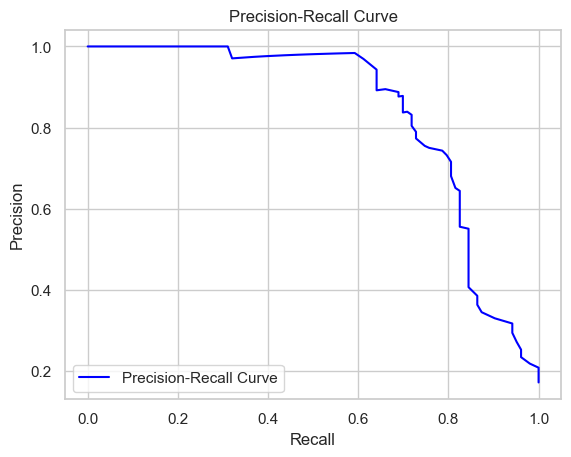

In [44]:
# Compute precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probas[:, 1])

# Plot the precision-recall curve
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [45]:
# Compute the false positive rate and true positive rate for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = roc_auc_score(y_test, probas[:, 1])

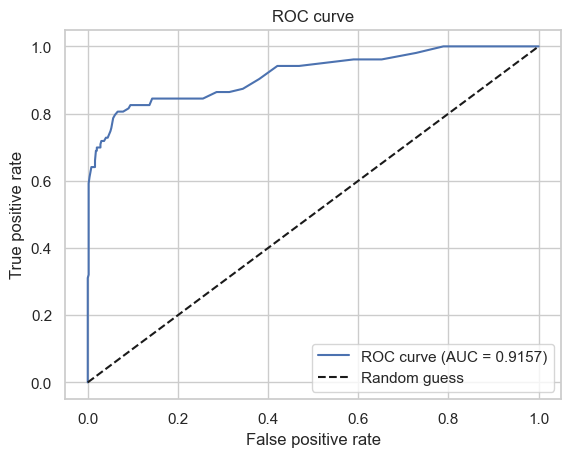

In [46]:
# Plot the ROC curve
plt.plot(fpr, tpr, linestyle='-', label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Conclusion
The model achieved an accuracy of 0.92833 and an F1 score of 0.73939. The model performed well in predicting the majority class (False) with a precision of 0.9219, recall of 0.9980, and F1 score of 0.9585. However, the model did not perform as well in predicting the minority class (True) with a precision of 0.9839, recall of 0.5922, and F1 score of 0.7394. The ROC AUC score was 0.91571